# The Drivers of Log Error in Single Unit Zestimates at Zillow
***

# Table of contents
1. [Introduction](#introduction)

# Introduction

### Author
- Samuel Davila
 - Data Scientist
 - Zillow DS Department

### Data source
- Single unit property data from Zillow table in Data Science Database
***

# Agenda

#### 1) Executive Summary
- General summary of project

#### 2) Data Acquisition
- How we acquired our data

#### 3) Preparation
- How we prepared our data for exploration

#### 4) Exploration
- How we explored our data and drew insights from it

#### 5) Modeling
- How we built various models and which performed the best

#### 6) Conclusion
- Takeaways, recommendations, predictions and ideas for the future
***

# Executive Summary

### Goals
- Improve original estimate of the log error by using clustering methodologies.
    - Identify drivers of log error
    - Create a model that predicts log error
    

- Deliver the following:

    - zillow_clustering_project.ipynb

    - README.md

    - acquire.py

    - prep.py

    - model.py
    
    - A presentation that walks through each step of our project and summarizes this notebook.

### Importance of Project
By identifying the drivers of log error, we have a better vision of where we should focus our efforts to improve our estimates.

### Analysis

Through data exploration and modeling, we found evidence that the following features are drivers of logerror
- bedroom_count
- property_sq_ft
- tax_dollar_value
- clusters created from a combination of bedroom_count and property_sq_ft

### Recommendation

- Improve the accuracy of our zillow estimate software using the insights and model generated from this project.

### Expectation

- By improving the accuracy of our zestimates we will increase satisfaction among our current users and make our services more attractive to potential users. 

***

# Acquire
Acquire the data we need for our project from the zillow table in the data science database.

Create __acquire.py__ file that contains the functions needed to replicate this process.
***

#### Importing modules needed for code in notebook to run.

In [1]:
# set up environment
from acquire import get_zillow_data
from prep import drop_missing_columns, missing_rows, drop_selected_columns, drop_more_selected_columns, compare_column_values
from prep import tax_columns_calculator, split_data, add_upper_outlier_columns, upper_outlier_data_print, data_scaler
from prep import outlier_remover, zillow_dummy, rfe_ranker, column_renamer, rfe_column_dropper, final_prep
from model import baseline_function, model_1_function, model_2_function, model_3_function

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE

import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

#### Using get_zillow_data function (acquire.py)  to import data 

In [2]:
# create variable that will hold DF for easy access to data
df = get_zillow_data()

# previewing data
df.head(2)

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,parcelid.1,logerror,transactiondate
0,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,3,12177905,-0.10341,2017-01-01
1,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,2016.0,45726.0,1533.89,NaN,NaN,6.037124e+13,4,10887214,0.00694,2017-01-01


### ACQUIRE TAKEAWAYS
- Acquiring data from zillow database on the data science database server using the __get_zillow_data__ function
- Function needed to replicate this phase is located in the __acquire.py__ file
***

# Prepare
Prepare, tidy, and clean the data for exploration and analysis.

Create __prep.py__ file that contains the functions needed to replicate this process.
***

#### We'll use .info to see null value counts, data types, and row / columns count.

In [3]:
# using info function to examine data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47414 entries, 0 to 47413
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            47414 non-null  int64  
 1   parcelid                      47414 non-null  int64  
 2   airconditioningtypeid         22070 non-null  float64
 3   architecturalstyletypeid      0 non-null      float64
 4   basementsqft                  0 non-null      float64
 5   bathroomcnt                   47414 non-null  float64
 6   bedroomcnt                    47414 non-null  float64
 7   buildingclasstypeid           8 non-null      float64
 8   buildingqualitytypeid         46923 non-null  float64
 9   calculatedbathnbr             47368 non-null  float64
 10  decktypeid                    0 non-null      float64
 11  finishedfloor1squarefeet      0 non-null      float64
 12  calculatedfinishedsquarefeet  47407 non-null  float64
 13  f

- Many columns have a large amount of null values
    - We'll be using our upcoming function, __missing_rows__ (prep.py) to examine the amount of null values in each column in more depth later
    - After examining in-depth, we'll decide how to deal with them


- Data types of several columns need to be converted 
    - We'll handle this in a later stage since the columns in question may be removed in an alternate step 
        - For example, we may remove a column with a bad data type due to it having too many nulls


- Several columns, such as rawcensustractandblock, are categorical variables that may have a very large amount of unique values
    - Encoding every value for these types of columns may be computationally expensive and add a large amount of columns to our dataset
        - We will need to set a cutoff amount for categorical column unique values and remove any columns that exceed this amount


- Once we've identified which columns to move into explore with, we'll need to rename them if they are hard to read, such as landtaxvaluedollarcnt


#### Using missing_rows function (prep.py) to create DF that shows the total number and percent of missing rows in each column of our data.

In [4]:
# function creates DF displaying number and percent of rows missing from each column
missing_rows(df)

,num_rows_missing,pct_rows_missing
id,0,0.000000
parcelid,0,0.000000
airconditioningtypeid,25344,53.452567
architecturalstyletypeid,47414,100.000000
basementsqft,47414,100.000000
...,...,...
censustractandblock,116,0.244653
id.1,0,0.000000
parcelid.1,0,0.000000
logerror,0,0.000000


- There are many columns with a substantial amount of missing values
    - We will remove any columns that are missing 40% or more of their values
    - We don't have an exact formula for why we should go with 40% but it seems reasonable to remove any columns that are missing that proportion of values.

#### Using drop_missing_columns function (prep.py) to remove columns that are missing 40% or more of their values.

In [5]:
# function removes any columns that are missing 40% or more of their values
df = drop_missing_columns(df)

# previewing data
df.head(2)

,id,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,id.1,parcelid.1,logerror,transactiondate
0,2288172,12177905,3.0,4.0,8.0,3.0,2376.0,2376.0,6037.0,3.0,...,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,3,12177905,-0.10341,2017-01-01
1,1970746,10887214,3.0,3.0,8.0,3.0,1312.0,1312.0,6037.0,3.0,...,73681.0,119407.0,2016.0,45726.0,1533.89,6.037124e+13,4,10887214,0.00694,2017-01-01


#### While examining the data in SQL, we noticed that several columns appeared to have identical values. 

#### Using compare_column_values (prep.py) to find how many unique values exist between the columns in question.

In [6]:
# function prints out sum of unique values between various columns
compare_column_values(df)

Number of different values between finishedsquarefeet12 and calculatedfinishedsquarefeet: 48
Number of different values between calculatedbathnbr and bathroomcnt: 46
Number of different values between fullbathcnt and bathroomcnt: 46


- The sum of non-duplicate values between all of these columns is 140 (48 + 46 + 46). 
    - This is roughly .003 of all rows in the DF
        - We can safely drop all the following majority-duplicate columns and only lose a extremely small proportion of rows.
            - finishedsquarefeet12
            - calculatedbathnbr
            - fullbathcnt
        - We could drop any of their alternativee columns instead but it would cost us time to find a non-arbitrary reason to do so and given how few unique values we're losing, the loss is relatively inconsequential.
        - These columns will be dropped in an upcoming function, __drop_selected_columns__ (prep.py), along with any other columns that are found to be in need of removal.

#### While examining the data in SQL, we noticed that taxvaluedollarcnt appeared to be the sum of landtaxvaluedollarcnt and structuretaxvaluedollarcnt. 

#### To test this we're going to use tax_columns_calculator (prep.py) to compare the sums of landtaxvaluedollarcnt and structuretaxvaluedollarcnt  to the values in taxvaluedollarcnt.

In [7]:
# function sums landtaxvaluedollarcnt and structuretaxvaluedollarcnt then prints the percent of rows where the sum matched taxvaluedollarcnt
tax_columns_calculator(df)

0.9986501877082719


- 99% of the our summed values matched the original 
    - Safe the say that in a vast majority of rows, taxvaluedollarcnt is the sum of landtaxvaluedollarcnt and structuretaxvaluedollarcnt
        - This being the case, we're only going to keep taxvaluedollarcnt and remove the other two columns since their values are already accounted for in this column.
        - If need be, we can add them back later and see if we get better results by having them seperated.
        - The columns will be dropped at a later step using the __drop_selected_columns__ (prep.py) function 

#### We're using .nunique to see how many unique values each column has. This is useful for identifying categorical columns with large amounts of unique values and columns with only a single value.

In [8]:
# nunique() displays each column and the amount of unique values that it holds
df.nunique()

id                              47293
parcelid                        47293
bathroomcnt                        13
bedroomcnt                         12
buildingqualitytypeid              12
calculatedbathnbr                  12
calculatedfinishedsquarefeet     4302
finishedsquarefeet12             4300
fips                                3
fullbathcnt                        12
heatingorsystemtypeid               3
latitude                        38668
longitude                       37041
lotsizesquarefeet               16506
propertycountylandusecode          40
propertylandusetypeid              10
propertyzoningdesc               1854
rawcensustractandblock          25212
regionidcity                      135
regionidcounty                      3
regionidzip                       290
roomcnt                             5
unitcnt                             1
yearbuilt                         131
structuretaxvaluedollarcnt      28782
taxvaluedollarcnt               32671
assessmentye

- The following are categorical columns will be removed because they contain more than 10 unique values. Encoding them would be computationaly expensive and add a large amount of columns to our dataframe.

    - id (both)
    - parcelid (both)
    - buildingqualitytypeid
    - latitude
    - longitude
    - propertylandusetypeid
    - propertycountylandusecode
    - propertyzoningdesc
    - rawcensustractandblock
    - regionidcity
    - regionidzip
    - yearbuilt
    - censustractandblock
    - transactiondate
    - id.1
    - parcelid.1
    
    
- There are ways to avoid the consequences of encoding categorical columns with lots of features, but in the interest of time we will avoid these routes for now.


- The following columns will be removed because they only contain 1 unique value and would thus not allow us to make any meaningful distinctions with them.

    - assessmentyear
    - unitcnt


- All of these columns will be removed using the __drop_selected_columns__ (prep.py) function

In [9]:
# function drop columns meeting any criterion above
df = drop_selected_columns(df)

df.head(2)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,heatingorsystemtypeid,lotsizesquarefeet,regionidcounty,roomcnt,taxvaluedollarcnt,taxamount,logerror
0,3.0,4.0,2376.0,6037.0,2.0,13038.0,3101.0,0.0,145143.0,1777.51,-0.10341
1,3.0,3.0,1312.0,6037.0,2.0,278581.0,3101.0,0.0,119407.0,1533.89,0.00694


#### Some of our columns are probably still missing data so we'll use our missing_rows (prep.py) function again to find what overall percent of rows are missing values.

In [10]:
# passing dataframe to missing_rows function
missing_rows_df = missing_rows(df)

# summing values in the percent of rows missing column
total_percent_rows_missing = round((missing_rows_df.pct_rows_missing).sum(),0)

print(f'At most, {total_percent_rows_missing}% of rows contain missing values.')

At most, 4.0% of rows contain missing values.


- In the interest of time, we will drop the remaining rows with missing values
    - Given how small this percentage is, it should be relatively inconsequential
    - If need be, we can add these rows back in at a later time

#### Dropping rows with missing values

In [11]:
# drop all rows with missing values
df.dropna(inplace = True)

#### RFE PREPARATION CHECKPOINT

At this point, we've removed a significant number of columns and taken care of our missing values.

Our remaining columns will be ranked using Recursive Feature Elimination (RFE) to determine which we will focus on during our initial venture through exploration. 

With that in mind, we'll need to prepare our columns for RFE by
- Ensuring our columns have valid data types
- Encoding categorical columns
- Idenfiying and handling outliers
- Splitting our data into train, validate and test (although we only need train for RFE)
- Scaling the data

### DATA TYPES

In [12]:
df.dtypes

bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
fips                            float64
heatingorsystemtypeid           float64
lotsizesquarefeet               float64
regionidcounty                  float64
roomcnt                         float64
taxvaluedollarcnt               float64
taxamount                       float64
logerror                        float64
dtype: object

- All columns have valid data types

### ENCODING

#### Before we encode our data, we need to identify our categorical columns so we know which columns to encode

In [13]:
# using nunique to review our data
df.nunique()

bathroomcnt                        13
bedroomcnt                         12
calculatedfinishedsquarefeet     4245
fips                                1
heatingorsystemtypeid               3
lotsizesquarefeet               16337
regionidcounty                      1
roomcnt                             1
taxvaluedollarcnt               31582
taxamount                       44224
logerror                        45105
dtype: int64

- After dropping all of our null values, we see that fips, regionidcounty and roomcnt have been reduced to one unique value each
    - We'll remove these columns since they are no longer useful to us with only one unique value
    - If need be, we can return to this stage, impute the missing values that were dropped earlier and retain these columns for exploration

#### Dropping columns with only 1 unique value remaining since all nulls were removed

In [14]:
# using function from prep.py to drop columns with only 1 unique value 
df = drop_more_selected_columns(df)

df.head(2)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,heatingorsystemtypeid,lotsizesquarefeet,taxvaluedollarcnt,taxamount,logerror
0,3.0,4.0,2376.0,2.0,13038.0,145143.0,1777.51,-0.10341
1,3.0,3.0,1312.0,2.0,278581.0,119407.0,1533.89,0.00694


- With those columns removed we can now encode our sole remaining categorical variable, heatingorsystemtypeid

#### Using zillow_dummy function (prep.py) to create dummy variables for heatingorsystemtypeid

In [15]:
# saving resulting df to variable
df = zillow_dummy(df)

# previewing dummy data
df.head(2)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,taxvaluedollarcnt,taxamount,logerror,heating_system_type_2,heating_system_type_7,heating_system_type_20
0,3.0,4.0,2376.0,13038.0,145143.0,1777.51,-0.10341,1,0,0
1,3.0,3.0,1312.0,278581.0,119407.0,1533.89,0.00694,1,0,0


- Dummy variables added succesfully, now we can split the data


### SPLIT

#### Using split_data function (prep.py) to split data into train, validate and test samples.

In [16]:
# function splits data into train, validate and test samples
train, validate, test = split_data(df)

# using shape to see count of rows and columns
train.shape

(25463, 10)

- We use .shape to confirm our number of rows reflects a split and it has

### OUTLIERS

#### We will now use our add_upper_outlier column function (prep.py) to add a column to our dataframe that will reflect how far above the upper boundary a corresponding outlier is, and if the corresponding value is not an outlier, it will contain a 0. 

#### UPDATE: We did not handle lower outliers on our initial venture through the prep phase in order to save time. After seeing the data in visualizations while exploring there did not appear to be many extreme lower outliers so we're not going to invest time in pursuing them.

In [17]:
# function used to identify outliers and their distance from the upper boundary
train = add_upper_outlier_columns(train, k=6)

# previewing data
train.head(2)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,taxvaluedollarcnt,taxamount,logerror,heating_system_type_2,heating_system_type_7,heating_system_type_20,bathroomcnt_upper_outliers,bedroomcnt_upper_outliers,calculatedfinishedsquarefeet_upper_outliers,lotsizesquarefeet_upper_outliers,taxvaluedollarcnt_upper_outliers,taxamount_upper_outliers,logerror_upper_outliers,heating_system_type_2_upper_outliers,heating_system_type_7_upper_outliers,heating_system_type_20_upper_outliers
44015,3.0,2.0,1150.0,10868.0,168859.0,2122.76,-0.007175,1,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
40095,3.0,5.0,1895.0,6746.0,428202.0,5519.32,0.003639,1,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0


- Outlier columns added successfully
- Although present, we're disregarding all heating systems outliers because they are categorical
- We're also disregarding logerror because we are not removing outliers from our target variable
    - We want our project to reflect the fact that we can't remove outliers in many real-world scenarios
- Set k to 6 which means that only the most extreme outliers will be identified
    - Normally k is set to 1.5 but when we tried this value earlier, we identified so many outliers than removing them all would cost us too much data

#### Now that we have our outlier data, we will use our outlier_data_print function (prep.py) to see on average, how far past the upper boundary each outlier is and how many there are per column.

In [18]:
# function gives a breakdown of outlier data, namely count and average distance from upper boundary
upper_outlier_data_print(train)

~~~
bathroomcnt_upper_outliers
count    7.000000
mean     1.857143
std      1.069045
min      1.000000
25%      1.000000
50%      2.000000
75%      2.000000
max      4.000000
Name: bathroomcnt_upper_outliers, dtype: float64
~~~
bedroomcnt_upper_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: bedroomcnt_upper_outliers, dtype: float64
~~~
calculatedfinishedsquarefeet_upper_outliers
count       77.000000
mean      2178.129870
std       2793.506024
min         14.000000
25%        468.000000
50%       1111.000000
75%       2877.000000
max      14958.000000
Name: calculatedfinishedsquarefeet_upper_outliers, dtype: float64
~~~
lotsizesquarefeet_upper_outliers
count    2.440000e+03
mean     1.997289e+05
std      2.853832e+05
min      2.400000e+01
25%      4.321000e+04
50%      1.085470e+05
75%      2.504595e+05
max      3.497243e+06
Name: lotsizesquarefeet_upper_outliers, dtype: float64
~~~
taxvaluedollarcnt_upper_outliers

- The "count" and "mean" values above are what we are focused on
     - Count tells us how many upper outliers we have
     - Mean tells us how far above the upper bound (UB) they are on average


- In total, we have 3,192 upper outliers, which is roughly 12% of our dataset
    - This is a fairly signifcant amount but this should be the last data removal step we do before RFE
    - Given that we set k so high earlier (6), these values are extreme outliers so we cannot overlook them


- With all this noted our plan is to remove all outliers as this is the most time-saving option we have
    - If we find that we need more data we can revisit this stage and impute the dropped values instead

#### Using outlier_remover function (prep.py) to remove all upper outliers within non-target variable and non-categorical variable columns

In [19]:
# function removes all upper outliers from non-categorical and non-target variable columns
train = outlier_remover(train)

# previewing data 
train.head(2)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,taxvaluedollarcnt,taxamount,logerror,heating_system_type_2,heating_system_type_7,heating_system_type_20,bathroomcnt_upper_outliers,bedroomcnt_upper_outliers,calculatedfinishedsquarefeet_upper_outliers,lotsizesquarefeet_upper_outliers,taxvaluedollarcnt_upper_outliers,taxamount_upper_outliers,logerror_upper_outliers,heating_system_type_2_upper_outliers,heating_system_type_7_upper_outliers,heating_system_type_20_upper_outliers
44015,3.0,2.0,1150.0,10868.0,168859.0,2122.76,-0.007175,1,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
40095,3.0,5.0,1895.0,6746.0,428202.0,5519.32,0.003639,1,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0


- all upper outliers dropped from appropriate columns

#### We don't need our outlier columns going forward so we'll drop them to simplify our dataset.

In [20]:
# creating list of outlier column names
outlier_cols = [col for col in train if col.endswith('_outliers')]

# dropping each column from list of outlier columns
train = train.drop(columns = outlier_cols)

# previewing data
train.head(2)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,taxvaluedollarcnt,taxamount,logerror,heating_system_type_2,heating_system_type_7,heating_system_type_20
44015,3.0,2.0,1150.0,10868.0,168859.0,2122.76,-0.007175,1,0,0
40095,3.0,5.0,1895.0,6746.0,428202.0,5519.32,0.003639,1,0,0


- Columns succesfully dropped

### SCALING

#### Using data_scaler (prep.py) to scale the data within our non-categorical and non-target variable columns.

#### We'll be keeping a set of unscaled dataframes for things such as visualizations.

In [21]:
# scaling appropriate numerical columns
train_scaled, validate_scaled, test_scaled = data_scaler(train, validate, test)

# previewing dataframe
train_scaled.head(2)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,taxvaluedollarcnt,taxamount,logerror,heating_system_type_2,heating_system_type_7,heating_system_type_20
44015,0.333333,0.181818,0.148556,0.111172,0.064023,0.064408,-0.007175,1,0,0
40095,0.333333,0.454545,0.259452,0.065931,0.164285,0.174718,0.003639,1,0,0


- Data scaled successfully
- We're not scaling any of our categorical columns (heatingsystemtypes) 
    - They are all binary values between 0 and 1 and thus don't need scaling
- We're not scaling logerror because its our target variable
- Our data is now ready for Recursive Feature Elimination

### RFE

#### Using rfe_ranker (prep.py) to rank the features in our train dataset via Recursive Feature Elimination.

In [22]:
# Function ranks features using RFE
rfe_ranker(train_scaled)

,Feature,Rank
2,calculatedfinishedsquarefeet,1
4,taxvaluedollarcnt,2
8,heating_system_type_20,3
7,heating_system_type_7,4
6,heating_system_type_2,5
1,bedroomcnt,6
0,bathroomcnt,7
5,taxamount,8
3,lotsizesquarefeet,9


- Recursive Feature Elimination ranks each feature with regard to how strong it is at predicting logerror when used as a feature in a model.


- We're going to move forward with our top 3 features in the exploration phase.
    - 3 features is an adequete number of features to begin working with and if we find that we are in need of more features, we can return to this step and bring in more
    - We're also planning on testing clusters as features in exploration, so this will also help supplement our feature count


- UPDATE: After spending time in explore, we found that although the heating_system columns ranked higher than bedroomcnt, they were not proving to be a statistically significant variable and we'd like more features when we get to modeling.
    - For this reason we will instead take the next highest ranked feature, bedroomcnt
    
    
- Thus the 3 features we are moving forward with are:
    - calculatedfinishedsquarefeet
    - taxvaluedollarcount
    - bedroomcnt

#### Now that we've identified our top 3 features, we're going to remove the others from our datasets

In [23]:
# function returns our dataframes with only the three we selected after RFE was performed
train, validate, test, train_scaled, validate_scaled, test_scaled = rfe_column_dropper(train, validate, test, train_scaled, validate_scaled, test_scaled)

# previewing data 
train_scaled.head(2)

,bedroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,logerror
44015,0.181818,0.148556,0.064023,-0.007175
40095,0.454545,0.259452,0.164285,0.003639


#### Now we'll rename our columns using our column_renamer function (prep.py) to finish our data prep. 

In [24]:
# function renames various columns for readability
column_renamer(train, validate, test, train_scaled, validate_scaled, test_scaled)

# previewing data 
train_scaled.head(2)

,bedroom_count,property_sq_ft,tax_dollar_value,log_error
44015,0.181818,0.148556,0.064023,-0.007175
40095,0.454545,0.259452,0.164285,0.003639


- Best features have been kept
- Column renaming was successful
- Prep is complete

### PREPARE TAKEAWAYS
- Dropped all columns that met any of the following criterion
    - 40% or more of their values missing
    - Duplicate or near-duplicate of other column(s)
    - Categorical with 10 or more unique values
    - Only contain 1 unique value
    - landtaxvaluedollarcnt and structuretaxvaluedollarcnt
        - Summed under taxvaluedollarcnt column
    - Was not found to be a top feature after RFE was run


- Dropped all rows with missing values


- Removed all extreme upper outliers from dataset 


- Scaled all numeric non-categorical, non-target variables


- Data types are valid


- Split data into train, validate and test sets


- Renamed columns for readability


- Columns we are moving into explore with are
    - bedroom_count	
    - property_sq_ft	
    - tax_dollar_value	
    - log_error


- All custom functions in this phase can be found in the __prepare.py__ and __prep.py__ files
    - When each function is appears in the notebook, the file it's located in is displayed next to it's name in ()
    - To retrieve the data fully prepared without any of the previous functions, you can alternatively run the __final_prep__ function (no arguments needed) from the __prep.py__ file
***

# Explore
We will now explore our prepped data to identify drivers of logerror and relationships between variables.

We will be using clustering to aid us in the latter half of our exploration.
***

## Non-Clustered Exploration

Let's begin our exploration by creating using visualizations and hypothesis tests to gauge the relationships between our features and our target variable. 

## Feature: property_sq_ft
Let's explore how the square feet of a property relates to log error. 

### Visualization - property_sq_ft
#### We'll begin by plotting the relationship between property_sq_ft and log_error

(-4, 4)

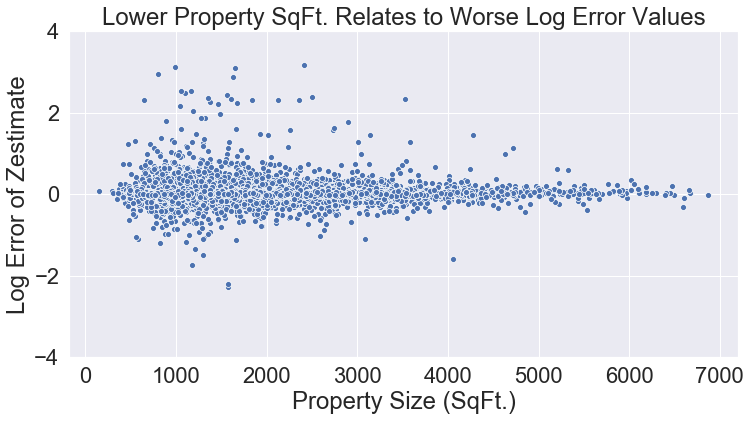

In [56]:
# setting figure and text size for plot
sns.set(rc = {'figure.figsize':(12,6)})
sns.set(font_scale = 2)

# creating scatter plot and setting title
sns.scatterplot(x = 'property_sq_ft', y = 'log_error', data = train).set_title("Lower Property SqFt. Relates to Worse Log Error Values")

# setting x and y labels
plt.xlabel("Property Size (SqFt.)")
plt.ylabel("Log Error of Zestimate")

# setting y limits
plt.ylim(-4, 4)

- The farther away from 0 a zestimate's log error is, the farther off from reality the zestimate was

- Generally, the smaller properties have log error values farther from 0 and thus different on average than larger properties
    - We'll perform a hypothesis test based on this observation

### Hypothesis Test - property_sq_ft

#### We'll now perform a two tailed, two sample t-test to see if smaller properties have different log error values than larger properties.

- H0 = Log error of properties with below avg. property_sq_ft __=__ Log error of properties with avg. or above avg. property_sq_ft
- Ha = Log error of properties with below avg. property_sq_ft __!=__ Log error of properties with avg. or above avg. property_sq_ft

In [58]:
# finding avg property_sq_ft
avg_property_sq_ft = train.property_sq_ft.mean()

# x1 = df of properties with property_sq_ft less than the avg.
# x2 = df of properties with property_sq_ft greater than or equal to the avg.
x1 = train[train.property_sq_ft < avg_property_sq_ft].log_error
x2 = train[train.property_sq_ft >= avg_property_sq_ft].log_error

# performing 2 tailed, 2 sample t-test
t, p = stats.ttest_ind(x1, x2)

# printing results
print(f'alpha = .05\n')
print (f'p = {p}')

alpha = .05

p = 0.019267236663996507


- p is below our alpha (.05) so we reject our null hypothesis and conclude there is evidence that properties with less than avg. square feet have different log error values than properties with avg. or above avg. square feet

- In light of this, we'll keep this feature as a candidate for modeling

## Feature: tax_dollar_value
Let's now explore how tax dollar value relates to log error. 

### Visualization - tax_dollar_value
#### We will plot the relationship between tax_dollar_value and log_error

Text(0, 0.5, 'Log Error of Zestimate')

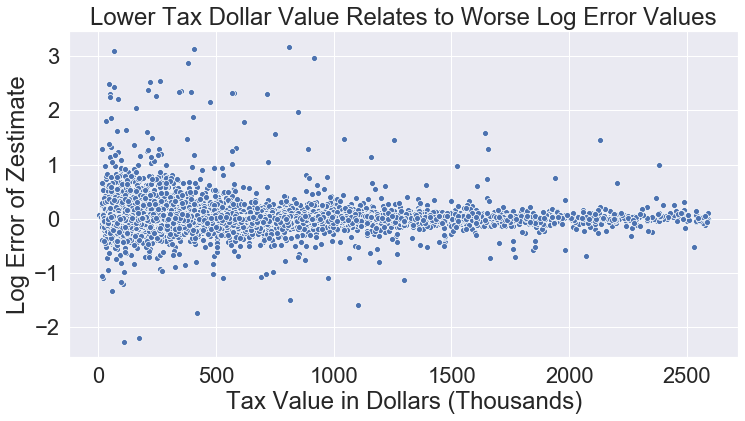

In [57]:
# setting figure and text size
sns.set(rc = {'figure.figsize':(12,6)})
sns.set(font_scale = 2)

# plotting data, setting title and scaling x axis values to simplify them
sns.scatterplot(x = train['tax_dollar_value'] / 1000, y = 'log_error', data = train).set_title("Lower Tax Dollar Value Relates to Worse Log Error Values")
plt.xlabel("Tax Value in Dollars (Thousands)")
plt.ylabel("Log Error of Zestimate")

- This visual looks very similar to our previous one and has similar takeaways

- The farther away from 0 a zestimate's log error is, the farther off from reality the zestimate was

- The lower value properties appear to have more log error values that are more distant from 0 than the higher value properties
       
- We'll perform a hypothesis test to see if lower value properties tend to have different log error values than high value properties

### Hypothesis Test - tax_dollar_value

#### Let's perform a two tailed, two sample t-test to see if properties with lower tax dollar values have different log error values than higher tax dollar value properties.

- H0 = Log error of properties with below avg. tax_dollar_value __=__ Log error of properties with avg. or above avg. tax_dollar_value
- Ha = Log error of properties with below avg. tax_dollar_value __!=__ Log error of properties with avg. or above avg. tax_dollar_value 

In [60]:
# finding avg tax dollar value
avg_tax_dollar_value = train.tax_dollar_value.mean()

# x1 = df of properties with tax dollar value less than the avg.
# x2 = df of properties with tax dollar value greater than or equal to the avg.
x1 = train[train.tax_dollar_value < avg_tax_dollar_value].log_error
x2 = train[train.tax_dollar_value >= avg_tax_dollar_value].log_error

# performing 2 tailed, 2 sample t-test
t, p = stats.ttest_ind(x1, x2)

# printing results
print(f'alpha = .05\n')
print (f'p = {p}')

alpha = .05

p = 0.0014316552820415878


- p is below our alpha (.05) so we reject our null hypothesis and conclude there is evidence that properties with lower sqft. have different log error values than high value properties
       
- Based on these observations, tax_dollar_value will remain a prospective feature for modeling

## Feature: bedroom_count
Let's now explore how the number of bedrooms in a property relates to log error. 

### Visualization - bedroom_count
#### We will plot the relationship between bedroom_count and log_error

Text(0, 0.5, 'Log Error of Zestimate')

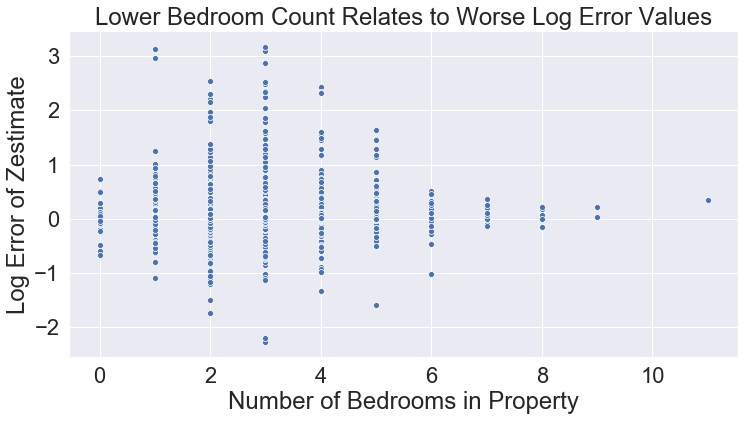

In [61]:
# setting figure size
sns.set(rc = {'figure.figsize':(12,6)})

# setting font size
sns.set(font_scale = 2)

# plotting scatterplot and setting title
sns.scatterplot(x = 'bedroom_count', y = 'log_error', data = train).set_title("Lower Bedroom Count Relates to Worse Log Error Values")

# setting x and y label
plt.xlabel("Number of Bedrooms in Property")
plt.ylabel("Log Error of Zestimate")

- Similar to our other features, we find that as the number of bedrooms decreases, our log error values pull farther away from 0
    - In other words, it appears that the less bedrooms a property has, the worse our zestimate tends to be
        - Interestingly, this does not appear to be true for properties with no bedrooms
            - If a property has no bedrooms, it may be a special kind of property that we are able to evaluate more effectively
            
            
- To support our observation we'll perform a hypothesis test to see if properties with lower amounts of bedrooms have different log error values than properties with higher amounts of bedrooms

### Hypothesis Test - bedroom_count

#### Let's perform a two tailed, two sample t-test to see if properties with less bedrooms have different log error values than properties with more bedrooms.

- H0 = Log error of properties with below avg. bedroom_count __=__ Log error of properties with avg. or above avg. bedroom_count
- H0 = Log error of properties with below avg. bedroom_count __!=__ Log error of properties with avg. or above avg. bedroom_count

In [31]:
# finding avg bedroom_count
avg_bedroom_count = train.bedroom_count.mean()

# x1 = df of properties with bedroom_count less than the avg.
# x2 = df of properties with bedroom_countgreater than or equal to the avg.
x1 = train[train.bedroom_count < avg_bedroom_count].log_error
x2 = train[train.bedroom_count >= avg_bedroom_count].log_error

# performing 2 tailed, 2 sample t-test
t, p = stats.ttest_ind(x1, x2)

# printing results
print(f'alpha = .05\n')
print (f'p = {p}')

alpha = .05

p = 0.00013267307569860408


- p is below our alpha (.05) so we reject our null hypothesis and conclude there is evidence that properties with lower than avg. bedroom counts have different log errors than properties with the avg. or more than the avg. number of bedrooms

- Based on our findings, bedroom_count should be considered a lucrative feature for predicting log error

## Clustered Exploration

Let's continue exploring by creating clusters that we can create hypothesis tests and visualizations with in order to gain further insight into the drivers of log_error.

It's important to cluster on scaled data when possible so we'll be using our scaled dataset here.

## Cluster Feature Set 1 - property_sq_ft | tax_dollar_value

Let's cluster using these two features and check if there is any difference between their log error values.

To begin, well use subplots to see what our clusters look like with different cluster amounts. This gives us a good idea of how many clusters we should choose for a given pair.

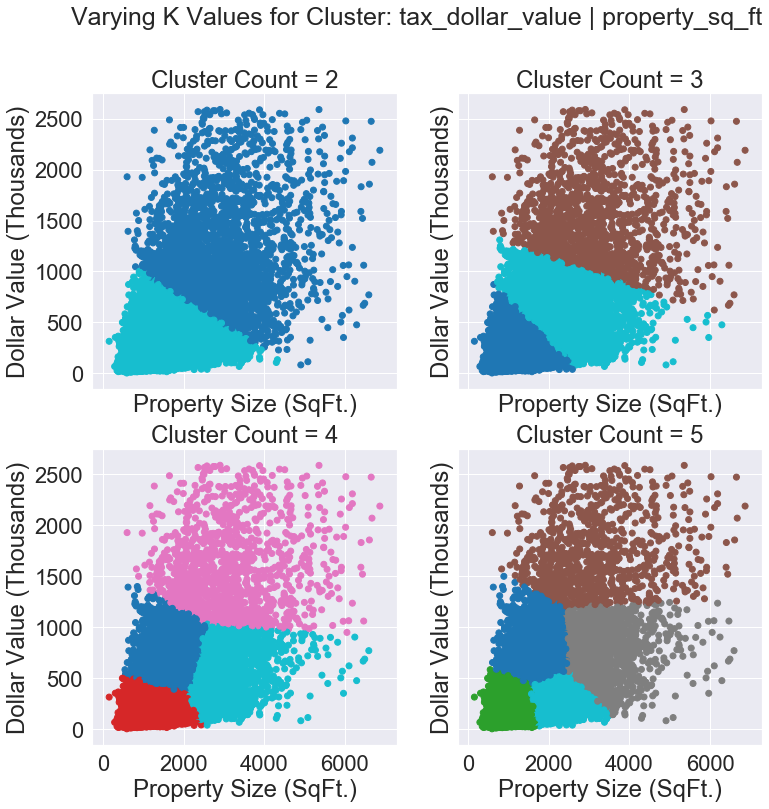

In [68]:
# creating scaled and unscaled DFs with the two features we want to cluster
# scaled for clustering, unscaled for plotting
X_c1 = train_scaled[['property_sq_ft', 'tax_dollar_value']]
X_c1_unscaled = train[['property_sq_ft', 'tax_dollar_value']]

# setting up subplots
fig, axs = plt.subplots(2, 2, figsize=(12,12), sharex=True, sharey=True)

# creating clusters, number of clusters increasing from 2 - 5
for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X_c1).predict(X_c1)
    X_c1_unscaled['clusters'] = clusters
    plt.suptitle('Varying K Values for Cluster: tax_dollar_value | property_sq_ft',fontsize=25)
    
    # plotting 
    sns.set(font_scale = 2)
    ax.scatter(X_c1_unscaled.property_sq_ft, X_c1_unscaled.tax_dollar_value / 1000, c=clusters, cmap = 'tab10')
    ax.set(title='Cluster Count = {}'.format(k), xlabel='Property Size (SqFt.)', ylabel='Dollar Value (Thousands)')

- We're looking for clean separation between clusters
    - All of them have relatively clean separation between eachother so this is a difficult choice
    - We'll go with 3 clusters to keep things simple while also having a larger variety of clusters to work with than the minimum

#### Now we'll create our 3 cluster types and add them to our dataframe

In [33]:
# making copy of train so we don't alter the original
train_k1 = train.copy()

# creating kmeans object and fitting to data
kmeans_1 = KMeans(n_clusters=3)
kmeans_1.fit(X_c1)

# creating clusters and adding as column
train_k1['cluster'] = kmeans_1.predict(X_c1)

#### Now we're going to examine our clusters in-depth and identify what they each represent.

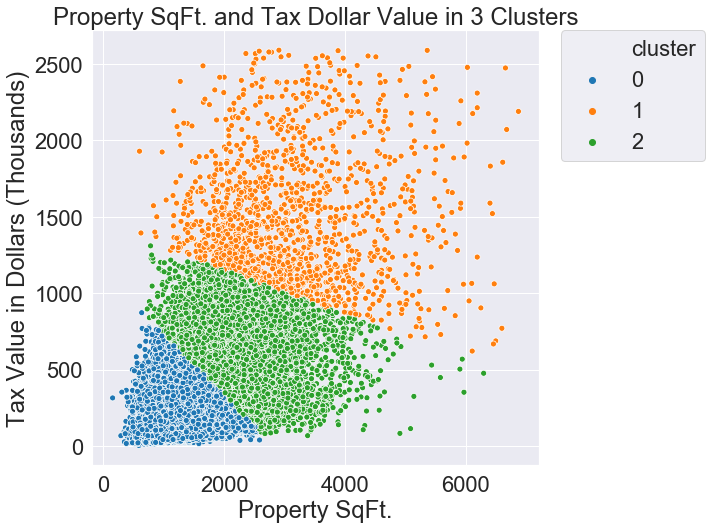

In [34]:
# setting figure and text size 
sns.set(rc = {'figure.figsize':(8,8)})
sns.set(font_scale = 2)

# plotting data, setting title and scaling y axis values to simplify them
sns.set(font_scale = 2)
sns.scatterplot(x = train_k1['property_sq_ft'], y = train_k1['tax_dollar_value'] / 1000, data = train_k1, hue = 'cluster', palette = 'tab10').set_title("Property SqFt. and Tax Dollar Value in 3 Clusters")
plt.xlabel("Property SqFt.")
plt.ylabel("Tax Value in Dollars (Thousands)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

- Cluster 0 is mostly 
    - low value
    - small-size properties


- Cluster 1 is mostly 
    - low-to-mid value 
    - small-to-medium size properties 

       
- Cluster 2 is mostly 
    - mid-to-high value 
    - small-to-medium size properties

### Cluster Feature Set 1 - Hypothesis Test

Now that we've identified the characterstics of our properties, we'll perform an ANOVA test to see if there are any differences between their average log errors.

- H0 = There is no difference between the average log error of cluster 0, cluster 1, and cluster 2
- Ha = There is a difference between the average log error of cluster 0, cluster 1, and cluster 2

In [63]:
# creating an array for the log error of each cluster type
cluster_0 = train_k1[train_k1.cluster == 0].log_error
cluster_1 = train_k1[train_k1.cluster == 1].log_error
cluster_2 = train_k1[train_k1.cluster == 2].log_error

# performing ANOVA test
f, p = stats.f_oneway(cluster_0, cluster_1, cluster_2)

# printing results
print(f'alpha = .05\n')
print(f'f = {f:.5f}')
print (f'p = {p}')

alpha = .05

f = 0.26959
p = 0.7636967299110946


- p is much greater than alpha
- We fail to reject our null hypothesis and conclude there is no difference in log error between the clusters
- In light of this, we will not be using this cluster for further analysis

## Cluster Feature Set 2 - property_sq_ft | bedroom_count

Let's cluster using these two features and check if there are any differences between their log error values.

To begin, well use subplots to see what our clusters look like with different cluster amounts. This gives us a good idea of how many clusters we should choose for a given pair.

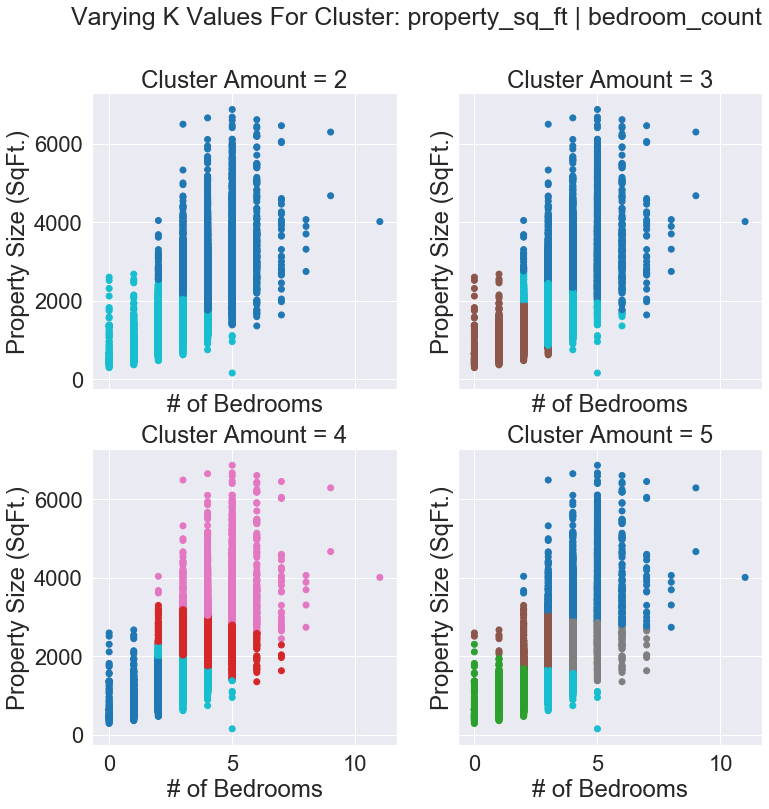

In [69]:
# creating DFs with the two features we want to cluster
# scaled for clustering, unscaled for plotting
X_c2 = train_scaled[['bedroom_count','property_sq_ft']]
X_c2_unscaled = train[['bedroom_count','property_sq_ft']]

# setting up subplots
fig, axs = plt.subplots(2, 2, figsize=(12,12), sharex=True, sharey=True)

# creating clusters, number of clusters increasing from 2 - 5
for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X_c2).predict(X_c2)
    X_c2_unscaled['clusters'] = clusters
    plt.suptitle('Varying K Values For Cluster: property_sq_ft | bedroom_count',fontsize=25)
    
    # plotting 
    sns.set(font_scale = 2)
    ax.scatter(X_c2_unscaled.bedroom_count, X_c2_unscaled.property_sq_ft, c=clusters, cmap = 'tab10')
    ax.set(title='Cluster Amount = {}'.format(k), ylabel='Property Size (SqFt.)', xlabel = '# of Bedrooms')

- Once again, we're looking for good separation between clusters
    - In this instance, cluster amounts 2 and 3 have the best separation
        - We'll stick with our strategy of using 3 clusters to make things simple while also having more than the minimum number of clusters
- Property square feet seems to be having a strong influence on our clusters since it was in both feature sets and we're seeing similar splits

#### Now we'll create our 3 cluster types and add them to our dataframe

In [70]:
# making copy of train so we don't alter the original
train_k2 = train.copy()

# creating kmeans object and fitting to data
kmeans_2 = KMeans(n_clusters=3)
kmeans_2.fit(X_c2)

# creating clusters and adding as column
train_k2['cluster'] = kmeans_2.predict(X_c2)

#### Now we're going to examine our clusters in-depth and identify what they each represent.

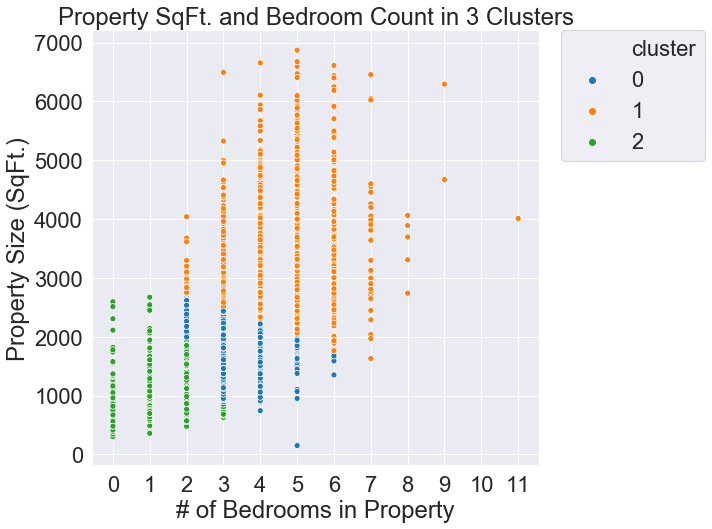

In [71]:
# setting figure and text size 
sns.set(rc = {'figure.figsize':(8,8)})
sns.set(font_scale = 2)

# plotting data, setting title and scaling y axis values to simplify them
sns.scatterplot(x = train_k2['bedroom_count'], y = train_k2['property_sq_ft'], data = train_k2, hue = 'cluster', palette = 'tab10').set_title("Property SqFt. and Bedroom Count in 3 Clusters")
plt.ylabel("Property Size (SqFt.)")
plt.xlabel("# of Bedrooms in Property")
plt.xticks(np.arange(0, 12, 1.0))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

- Cluster 0 is mostly
    - low-to-medium bedroom count 
    - small size properties
    
- Cluster 1 is mostly
    - medium-to-high bedroom count
    - medium-to-large size properties
    
- Cluster 2 is mostly 
    - low bedroom count
    - small size properties

### Cluster Feature Set 2 - Hypothesis Test - ANOVA

Now that we've identified the characterstics of our properties, we'll perform an ANOVA test to see if there is any difference in their average log errors.

- H0 = There is no difference between the average log error of cluster 0, cluster 1, and cluster 2
- Ha = There is a difference between the average log error of cluster 0, cluster 1, and cluster 2

In [72]:
# creating an array for the log error of each cluster type
cluster_0 = train_k2[train_k2.cluster == 0].log_error
cluster_1 = train_k2[train_k2.cluster == 1].log_error
cluster_2 = train_k2[train_k2.cluster == 2].log_error

# performing ANOVA test
f, p = stats.f_oneway(cluster_0, cluster_1, cluster_2)

# printing results
print(f'alpha = .05\n')
print (f'p = {p}')

alpha = .05

p = 0.0009461784659704397


- p is less than alpha
- We reject our null hypothesis and conclude there is a difference in the average log error of the clusters
- Since these clusters appear to relate to log error, we'll use them as features in our modeling phase

## CLUSTER FEATURE SET 3 - Bedroom_Count | Tax_Dollar_Value 

Let's cluster using these two features and check if there is any difference between their log error values.

To begin, well use subplots to see what are clusters look like with different cluster amounts. This gives us a good idea of how many clusters we should choose for a given pair.

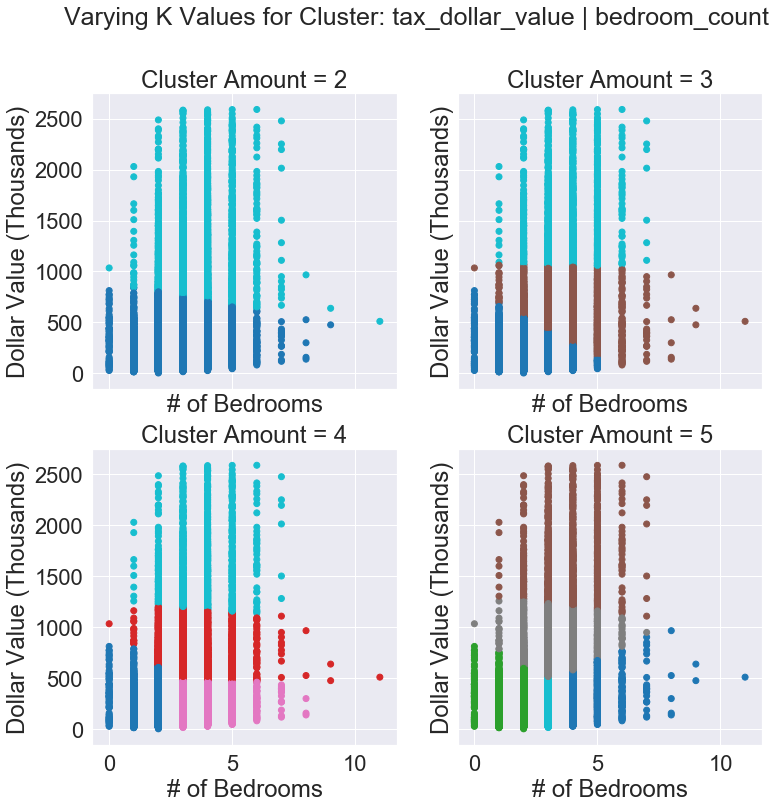

In [73]:
# creating df with the two features we want to cluster
# scaled for clustering, unscaled for plotting
X_c3 = train_scaled[['bedroom_count','tax_dollar_value']]
X_c3_unscaled = train[['bedroom_count','tax_dollar_value']]

# setting up subplots
fig, axs = plt.subplots(2, 2, figsize=(12,12), sharex=True, sharey=True)

# creating clusters, number of clusters increasing from 2 - 5
for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X_c3).predict(X_c3)
    X_c3_unscaled['clusters'] = clusters
    plt.suptitle('Varying K Values for Cluster: tax_dollar_value | bedroom_count',fontsize=25)
    
    # plotting 
    sns.set(font_scale = 2)
    ax.scatter(X_c3_unscaled.bedroom_count, X_c3_unscaled.tax_dollar_value / 1000, c = clusters, cmap = 'tab10')
    ax.set(title='Cluster Amount = {}'.format(k), ylabel='Dollar Value (Thousands)', xlabel='# of Bedrooms')

- Still looking for clean separation and only cluster counts 2 and 3 depict this
    - Once again we'll opt for 3 to keep things simple while also have an extra cluster beyond the minimum to work with

#### Now we'll create our 3 cluster types and add them to our dataframe

In [74]:
# making copy of train so we don't alter the original
train_k3 = train.copy()

# creating kmeans object and fitting to data
kmeans_3 = KMeans(n_clusters=3)
kmeans_3.fit(X_c3)

# creating clusters and adding as column
train_k3['cluster'] = kmeans_3.predict(X_c3)

#### Now we're going to examine our clusters in-depth and identify what they each represent.

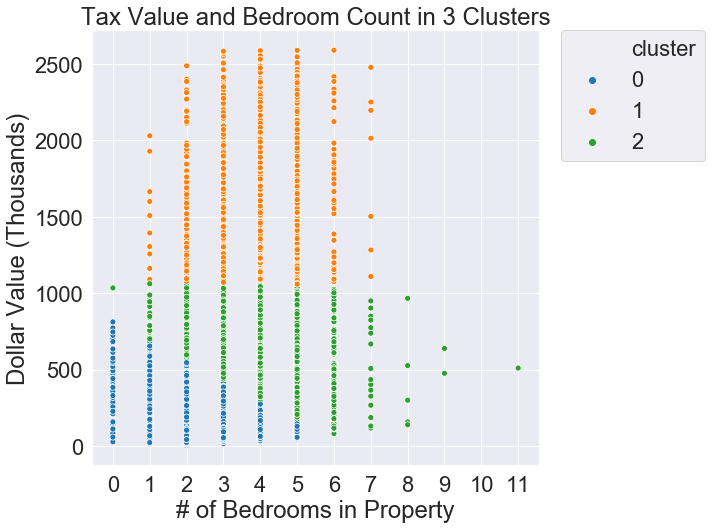

In [75]:
# setting figure and text size 
sns.set(rc = {'figure.figsize':(8,8)})
sns.set(font_scale = 2)

# plotting data, setting title and scaling y axis values to simplify them
sns.scatterplot(x = train_k3['bedroom_count'], y = train_k3['tax_dollar_value']/1000, data = train_k3, hue = 'cluster', palette = 'tab10').set_title("Tax Value and Bedroom Count in 3 Clusters")
plt.ylabel("Dollar Value (Thousands)")
plt.xlabel("# of Bedrooms in Property")
plt.xticks(np.arange(0, 12, 1.0))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

- Cluster 0 is mostly
    - Low bedroom count, low value properties


- Cluster 1 is mostly
    - Low-to-medium bedroom count, medium-to-high value properties
    

- Cluster 2 is mostly
    - Low-to-medium bedroom count, low-to-medium value properties

## Cluster Feature set 3 - Hypothesis Test

Now that we've identified the characterstics of our properties, we'll perform an ANOVA test to see if there is any difference between their average log errors.

- H0 = There is no difference between the average log error of cluster 0, cluster 1, and cluster 2
- Ha = There is a difference between the average log error of cluster 0, cluster 1, and cluster 2

In [76]:
# creating an array for the log error of each cluster type
cluster_0 = train_k3[train_k3.cluster == 0].log_error
cluster_1 = train_k3[train_k3.cluster == 1].log_error
cluster_2 = train_k3[train_k3.cluster == 2].log_error

# performing ANOVA test
f, p = stats.f_oneway(cluster_0, cluster_1, cluster_2)

# printing results
print(f'alpha = .05\n')
print(f'f = {f:.5f}')
print (f'p = {p}')

alpha = .05

f = 1.53545
p = 0.21538041952998221


- p is much greater than alpha

- We fail to reject our null hypothesis and conclude there is no difference in log error between the clusters

- For these reasons we will not be using this cluster for further analysis

### Exploration Takeaways

__Non-Clustered Exploration__


- Visualization and hypothesis tests suggest that the following features are drivers of log_error
    - property_sq_ft
    - tax_dollar_value
    - bedroom_count


__Clustered Exploration__


- Created 3 clusters for each pair of features below
        - Feature set 1: property_sq_ft | tax_dollar_value
        - Feature set 2: property_sq_ft | bedroom_count
        - Feature set 3: bedroom_count | tax_dollar_value


- Ran ANOVA tests on each pair's clusters to determine if there were any differences in log error
    - Only the clusters created using property_sq_ft and bedroom_count showed differences in log error
        - If log errors meaningfully fluctuate between these cluster types, they may be useful as features in our model to predict log error 


__Moving Forward__


- We will now move into modeling with the following as prospective features
    - tax_dollar_value
    - property_sq_ft
    - bedroom_count
    - Feature set 2's clusters
***

## Modeling
We'll now construct several models that will attempt to predict the log error associated with each property. 

We'll also create a __model.py__ file that contains the custom functions used in this phase.
***

## TRAIN
We'll create a baseline model that our other models must outperform.

Next we'll create 3 alternate models. The 2 best that outperform our baseline will be taken to validation.

### Baseline Model
Our baseline model that will always predict log error to be the sample's average log error. 

The RMSE value is predictions produce will also serve as the benchmark that our alternate models will seek to outperform.

In [77]:
baseline_function(train_scaled)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.154544


- Baseline RMSE is .154544 and the metric our other models need to improve upon

### Model 1 (All Feature Model)
Overview: Let's create a model that uses all of the features from our exploration phase including clusters.

Model type: Linear Regression


Model Features 
- property_sq_ft
- tax_dollar_value
- bedroom_count
- clusters
    - cluster features: property_sq_ft and bedroom_count
    - number of clusters: 3

In [80]:
model_1_function(train_scaled, train_scaled)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.154375


- RMSE value is below baseline's (an improvement)
- If this model outperforms either of the other models it will go to validation

### Model 2 (No Clusters Model)
Overview: Let's create a model that uses all of the features from our exploration phase without any clusters.

Model type: Linear Regression


Model Features 
- property_sq_ft
- tax_dollar_value
- bedroom_count

In [79]:
model_2_function(train_scaled, train_scaled)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.154379


- Model outperformed baseline but worse than model 1 which used clusters
    - This suggests clusters are effective at improving log error predictions 

### Model 3 (All Clusters Model)
Overview: Since our last model performed worse without clusters, let's see how a model will perform with only clusters. It's possible that the clusters are so effective that the non-cluster features are creating noise which is worsening performance.

Model type: Linear Regression


Model Features 
- clusters
    - features: property_sq_ft and bedroom_count
    - number of clusters: 3

In [47]:
model_3_function(train_scaled, train_scaled)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.15439


- This model outperformed the baseline but worse than our other 2 models
- We're only taking our best 2 models to validation so this one will be left behind
- It appears that our model performs better non-cluster features

### VALIDATE
Our top 2 models from the train dataset phase will now be used on the validate dataset.

The best model model will be taken to the test phase.

### Model 1 (All Feature Model)

In [81]:
model_1_function(train_scaled, validate_scaled)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.150673


### Model 2 (No Clusters Model)

In [82]:
model_2_function(train_scaled, validate_scaled)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.150667


- This gives us an idea of how our models will perform on unseen data (out of sample)
- Model 2 outperformed model 1 so it will be taken to the test phase
- Interesting to note that our cluster model was outperformed better by our non-cluster model in validate (out of sample) but no on train (in sample)
    - One possible explanation is that by chance, the feature data used to make the clusters (bedroom_count and property_sq_ft) in our validate sample is much different than our train sample, so model 1's performance was more heavily affected by its unfamiliarity with this data.

### TEST
Our best model from the validate phase will now be used on the test dataset.

### Model 2 (No Clusters Model)

In [83]:
model_2_function(train_scaled, test_scaled)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.158962


- Our model performed worse on the test data than on the validate data.
    - This is very interesting considering that both of validate and test are out-of-sample datasets
    - A possible explanation for this could be that by chance, the data from train and validate was very similar and so the model performed better on validate since its data was similar to the data it was fitted on

### Modeling Takeaways

Created 4 models 
    
- Baseline
    - Always predicts average logerror
        
        
- Model 1 (All features)
    - Linear Regression
    - Features 
        - property_sq_ft
        - tax_dollar_value
        - bedroom_count
        - clusters
            - cluster features: property_sq_ft and bedroom_count
            - number of clusters: 3
                
                
- Model 2 (No clusters)
    - Linear Regression
    - Features
        - property_sq_ft
        - tax_dollar_value
        - bedroom_count
            
            
- Model 3 (All clusters)
    - Linear Regression
    - Features 
        - clusters
            - cluster features: property_sq_ft and bedroom_count
            - number of clusters: 3
        
Model 1 performance details
- Proved to be best model by outperforming the other models with regard to RMSE value on predictions for log error
- Performed better on validate sample than on test sample
    - Possible explanation is that by chance, the sample it was fitted on, train, had very similar data to the validate sample, but not the test sample.
    
All custom functions used in this phase are available in the __model.py__ file located in this repository.
***

## Overall Conclusion and Takeaways

__Summary of Findings__

Through visualizations, hypothesis tests and modeling, we discovered evidence that drivers of log_error include 
- bedroom_count
- property_sq_ft
- tax_dollar_value
- clusters created from a combination of bedroom_count and property_sq_ft

We created several models including a baseline that always predicted logerror to be the sample average

- Each model's performance was evaluated based on the RMSE value produced by comparing its prediction of logerror values vs. actual log error values


- Model 2 was the best performer (specs listed below)

    - Type: Linear Regression
    
    - Features: Uses all features listed above, except for clusters
    
    
- Although this model did not use clusters as features and outperformed models that did, our clustering algorithm is very unrefined. With time it could be improved and incorporated into this model to improve its performance


- It should be noted that our second best model used clusters and was only outperformed by our non-cluster model by a small margine. This is further evidence that clusters may still be useful for predicting log errors.
    
__Recommendation__
- Begin a project to improve the accuracy of our zillow estimate software using the insights and model generated from this project


__Expectations__
- By improving the accuracy of our zestimates we will increase satisfaction among our current users and make our services more attractive to potential users. 


__In the future__
- I'd like to revisit this project and explore / model with clusters more. A new combination of cluster features may generate clusters that prove to be very useful in predicting log error. I'd also like to try imputing some of the null values we dropped and observe how that influences our hypothesis tests and modeling.
***